# Introduction

This tutorial will cover how to use webscraping to do some basic sports analytics. Sports analytics is one of the most public-friendly usages of data science as it requires no special knowledge to comprehend the results beyond a basic understanding of the subject sport. Despite the relatively low barrier of entry, the field also has an incredible amount of depth due to the large quantity of resources funneled into the field by both the teams themselves as well as by the gambling community.

The tutorial will work in the context of predicting the number of points a player will score versus a given team. In particular, the tutorial will try to predict how many points Lebron James will score against the Charlotte Hornets. That being said, the tutorial applies to any player or team.

### Data Sources
In this tutorial we will be getting our data from the website https://www.basketball-reference.com/ which is one of the leading data sources for public use when it comes to professional basketball. Other popular sources include http://www.sportsdatabase.com/ and http://stats.nba.com/.

# Setup

### Libraries

Here is a breakdown of the libraries used in this tutorial and how to install them if you do not already have them:

##### requests
This is the library we use to get the raw html from the websites. You can install this package using pip with the following command:
    
    $ pip install requests
    
##### BeautifulSoup4
This is the library we use to parse the raw html and to search and identify the tables we need from the websites. It can be installed using the following command:

    $ pip install beautifulsoup4

##### pandas
We use the dataframes from pandas to organize and process our data into data structures we can more easily work with. Pandas can be installed with the following command:

    $ pip install pandas

or with the following command if you use Anaconda:
    $ conda install pandas
    
##### numpy
Numpy is the library we use to facilitate much of the mathematical operations used in this tutorial and in particular for any vectorized mathematics. This library should be installed already as a dependency of pandas

##### re
re is the regex library we use to filter parts of our html. This library is more specific for use with basketball-reference.com due to some syntactical oddities with the website. This is installed by default with python.



### Verification
Once you have installed the above dependencies, make sure that you can import the packages by making sure the code below can run without errors.

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import numpy as np

# Methodology

Perhaps the easiest way to predict a players performance against a given team is simply to take the averages of their past performances against said team and use that as the prediction. There are a couple flaws with this method however. The primary flaw is that teams are volatile and in between the last time a player faced a given team and the next time they face that team players could get injured or new players might get hired which changes a team drastically. Additionally, this method is susceptible to players simply having an off-night or having a one-off performance.

The method we will use will expand upon the simplistic method by including a players performance against all teams. We will assign each team a score from 0-1 based upon their similarity to the team we are trying to predict against. The predicted performance of the player will then be a weighted average of their performances against each team weighted by the similarity scores.

The main advantages of this method are that it helps mitigate the effects of unusual performances by a player by increasing the sample size while allowing us to still put a focus on the team being targeted. Alternatively, we could have done similarity scores by player instead of by team and taken the average of all players performances against the target team.

# Loading the Team Data

To construct the similarity scores, we will need to first parse all of the teams per-game stats into a dataframe we can easily use for computation.

### Team HTML

Finding the correct URL unfortunately is a process that requires human interaction. Fortunately for us basketball-reference conveniently organizes data into tables which can be directly linked via url.

<img src="https://i.imgur.com/5h6cnql.png?1">

Once we have found the URL we grab it using the requests library and then extracting the raw text from the response body.

In [3]:
#Acquire the raw html
html_text = requests.get("https://www.basketball-reference.com/leagues/NBA_2018.html#team-stats-per_game::1").text

By inspecting the html through your web browser of choice, we can see that the table is actually encapsulated in a comment string(which in html takes the form <!-- COMMENT --\>). To take care of this, we use our regex library to replace the comment characters with empty strings. Note that if we did not do this BeautifulSoup would not be able to find the table as it does not search comments.

In [4]:
#Remove the comments
html_text = re.sub("<!--|-->","",html_text)

### Build the teams table

Now that we have the html, we need to parse it into our dataframe. We begin by converting the raw html into a BeautifulSoup object which will allow us to actually parse through it

In [5]:
#Parse it into a BeautifulSoup object
soup = BeautifulSoup(html_text, "lxml")

Unfortunately for us, the html returned contains multiple different tables and only one of which is the table we care about. Inspecting the data, we see that each table has attribute `id` which is unique to that table. Via inspection using your favorite web browser, we can identify the ID for the oppenent per-game stats table.

In [6]:
#Isolate the desired table by ID
table = soup.find(id = "all_opponent-stats-per_game")

In html, tables are encoded as elements `tr`. Each row is essentially a list of elements. If these elements are table headers then they are encoded as `th` and if they are data fields they are encoded as `td`. Using this knowledge we can extract the column headers as an array of strings using the `.getText()` method. We will use these column headers when constructing our dataframe to make the dataframe human-readable.

In [7]:
#Extract column headers
headers = table.find("tr")
headers = [th.getText() for th in table.find("tr").findAll("th")]
headers = headers[1:]#Drop the rank column since we don't actually use this at all

Similarly, we can extract the data fields by grabbing the rest of the table rows and then parsing each of the `td` fields for each row. Once we have these data fields we can construct the raw pandas dataframe.

In [8]:
#Extract the teams
teams = table.findAll("tr")[1:31]

#Convert to pandas dataframe
team_data = [[td.getText() for td in teams[i].findAll('td')] for i in range(len(teams))]
team_df = pd.DataFrame(team_data, columns = headers)

Now that we have the dataframe, there's a bunch of basic data cleanup to be done. The first step in data cleanup(assuming there are no `NaN` values to take care of) should usually be type conversions. By default, all the fields in the dataframe are `object` types. For our purposes, we want to convert the `Team` column to a string column and all the numeric fields to `float64` so we can use them in our math later.

In [9]:
#Type conversions
headers.remove("Team")
team_headers = headers#Store for later
team_df["Team"] = team_df["Team"].astype('str')
for col in headers:
    team_df[col] = team_df[col].astype('float64')

Finally, for consistency sake we'll order our teams alphabetically and also remove the team the player is actively playing on since a player can't play their own teams.

In [10]:
#Reorder the team names alphabetically
team_df = team_df.sort_values('Team')

#You can't play your own team so ignore those stats
team_df = team_df[team_df["Team"] != "Cleveland Cavaliers*"]
team_df

,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
24,Atlanta Hawks,75.0,240.3,40.8,86.3,0.472,11.6,30.5,0.381,29.2,...,0.774,10.3,33.6,43.9,26.1,8.7,5.4,15.3,20.6,109.2
1,Boston Celtics*,75.0,241.7,37.1,85.0,0.437,9.2,27.3,0.338,27.9,...,0.765,9.7,34.1,43.8,20.9,7.2,4.5,14.0,18.9,100.1
27,Brooklyn Nets,75.0,242.0,41.6,89.2,0.466,9.2,24.7,0.372,32.4,...,0.766,10.4,36.1,46.5,21.8,7.6,5.5,12.3,19.9,110.5
23,Charlotte Hornets,76.0,241.3,40.8,87.3,0.468,11.2,30.0,0.374,29.6,...,0.799,8.3,35.4,43.7,24.5,6.5,5.0,13.8,22.6,107.8
21,Chicago Bulls,74.0,242.4,41.0,86.9,0.472,11.9,32.2,0.371,29.1,...,0.785,8.5,37.2,45.7,25.8,7.1,5.0,13.3,17.4,110.2
14,Dallas Mavericks,75.0,241.3,39.1,83.6,0.467,10.7,29.4,0.364,28.4,...,0.758,9.0,36.6,45.6,23.3,7.3,4.5,13.9,19.9,105.2
20,Denver Nuggets,75.0,241.7,41.3,86.1,0.480,11.0,28.9,0.380,30.3,...,0.740,9.5,31.9,41.4,25.0,7.9,5.0,14.1,20.4,108.5
3,Detroit Pistons,74.0,241.4,38.9,84.9,0.458,11.0,30.4,0.361,27.9,...,0.778,9.2,34.6,43.9,24.9,7.3,5.0,14.9,18.4,103.8
15,Golden State Warriors*,74.0,240.7,39.9,90.0,0.443,10.3,29.0,0.356,29.5,...,0.755,10.9,31.3,42.2,23.2,8.6,3.6,14.3,18.5,107.0
9,Houston Rockets*,75.0,241.0,39.7,85.8,0.462,10.2,29.0,0.352,29.5,...,0.749,8.7,33.1,41.8,22.5,7.3,4.5,14.6,20.5,104.2


# Build the Similarity Scores

## Normalzation

Now that we have our team data cleaned and organized, we need to actually construct the similarity scores for use in our weighted average. The first step is to normalize/scale our data by subtracting the mean and dividing by the standard deviation. The result of this is that every column will have mean 0 and standard deviation 1. If we didn't do this then certain fields would be weighted unfairly when calculating similarity. 

In [11]:
def normalize(col):
    if col.dtype != 'float64':#Ignore teams column
        return col
    sd = np.std(col)
    mu = np.mean(col)
    return (col - mu)/sd

normalized_df = team_df
normalized_df = normalized_df.apply(normalize, axis = 0)
normalized_df.head(5)

,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
24,Atlanta Hawks,0.219529,-1.353367,0.892954,0.175528,1.081443,1.396313,0.863320,1.549709,0.104688,...,0.385048,0.848228,-0.055708,0.339882,1.968549,1.610784,1.124253,1.231617,0.568306,0.872607
1,Boston Celtics*,0.219529,0.379967,-1.635120,-0.341457,-2.054741,-1.478935,-0.781775,-1.996139,-0.857930,...,-0.308038,-0.009863,0.280861,0.271905,-1.370677,-0.830648,-0.698294,-0.414907,-0.832568,-1.820738
27,Brooklyn Nets,0.219529,0.751396,1.439565,1.328802,0.543811,-1.478935,-2.118415,0.807555,2.474210,...,-0.231029,0.991243,1.627138,2.107265,-0.792734,-0.179600,1.326759,-2.568053,-0.008525,1.257371
23,Charlotte Hornets,1.811110,-0.115271,0.892954,0.573209,0.723022,0.917105,0.606274,0.972478,0.400878,...,2.310286,-2.012075,1.155941,0.203929,0.941095,-1.969984,0.314232,-0.668218,2.216392,0.458246
21,Chicago Bulls,-1.372053,1.246634,1.029607,0.414136,1.081443,1.755719,1.737277,0.725093,0.030640,...,1.232153,-1.726045,2.367590,1.563455,1.775902,-0.993411,0.314232,-1.301496,-2.068633,1.168579


## Calculation

Now that we have prepared our dataframe, we can calculate the similarity scores. We begin by ideintifying our target team and isolating their normalized row. 

In [12]:
target_team = "Charlotte Hornets"
target_index = team_df.index[team_df["Team"] == target_team]#Find the index
target_row = normalized_df.loc[target_index]#Extract normalized row
target_row

,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
23,Charlotte Hornets,1.81111,-0.115271,0.892954,0.573209,0.723022,0.917105,0.606274,0.972478,0.400878,...,2.310286,-2.012075,1.155941,0.203929,0.941095,-1.969984,0.314232,-0.668218,2.216392,0.458246


In this tutorial, we will calculate our similarity scores using euclidean distance. The euclidean distance is simply the sum of squared differences between the two rows. To get the similarity scores from the distances we take the inverse so that values which have less distance(and as such are "closer") have a higher similarity and vice versa. We also add 1 to the distances so that the maximum similarity score is 1.

In [13]:
def similarity(row1, row2):
    dist = 0
    for col in team_headers:
        if col != "Team":
            dist += (row1[col] - row2[col]) ** 2
    dist = np.sqrt(dist)
    
    return 1/(1 + dist)

Finally, we just need to apply the similarity function to every row using the target row as `row2`. Once we have the similarities, we take the square root of each similarity so that other teams have increased weight. Otherwise the weighted average would be dominated by the target team's score.

In [14]:
similarities = normalized_df.apply(similarity, axis = 1, args = (target_row,))**0.5
similarities = similarities[similarities.columns[0]].tolist()
similarities

[0.36647357975205824,
 0.31930259212215417,
 0.32214334339360046,
 1.0,
 0.36362264260738586,
 0.3822977620754107,
 0.3570185667273443,
 0.371389787946539,
 0.30269568346509507,
 0.3737863675208652,
 0.34453445125526994,
 0.3617853324228386,
 0.3481418096908498,
 0.3089012968631504,
 0.33977818358740103,
 0.3432526820465865,
 0.4034825297458893,
 0.3501836796015848,
 0.35566947377645286,
 0.3571055033377526,
 0.3441003730542311,
 0.29764528279993097,
 0.33619563672168234,
 0.34003036615188836,
 0.34323872466149635,
 0.33153467241234624,
 0.3320180827574491,
 0.3342023702395961,
 0.3346201698040487]

## Extracting Player Stats

Now that we have the team statistics, we need to collect the player data. You'll notice that the procedure here is very similar to the team data collection. Here we aim to get the player's performance against every team for the current season. Data for players is organized into what are referred to as "splits" which are just different subsets of that players performances. For example, splitting by seasons gives you different season splits. In our case we are looking for the player's splits by team.

### Extracting Raw HTML

This portion is exactly the same as it was for the team data except that we use a different URL.

In [15]:
#Acquire the raw html
html_text = requests.get("https://www.basketball-reference.com/players/j/jamesle01/splits/2018").text

#Remove the comments
html_text = re.sub("<!--|-->","",html_text)

#Parse it into a BeautifulSoup object
soup = BeautifulSoup(html_text, "lxml")

### Building the Player Table

The process here again begins much the same as it did for the teams data. By inspection we find that the table we desire has id splits. Once we find the table we extract the headers using the `th` fields.

In [16]:
#Isolate the desired table by ID
table = soup.find(id = "splits")

#Extract column headers
headers = [th.getText() for th in table.findAll("tr")[1].findAll("th")]

Here's where the major difference appears between the team data and the player data. While the team data was split across multiple tables allowing us to just choose the table we desired, the player data is actually all in one large table where different splits are just subsets of rows.

<img src="https://i.imgur.com/bbLpTH9.png">

Fortunately for us, the splits by opponent teams are at the end of the table so we only need to find the start of that section. To find this, we scan every row in the table until we find the row with header "Opponent".

In [17]:
#Find the part we care about
rows = soup.findAll("tr")
for i in range(len(rows)):
    row = rows[i]
    if row.find("th").getText() == "Opponent":
        cutoff = i
        break

#Extract the rows
stats = table.findAll("tr")[cutoff:]

Once we have stored the data in a dataframe, there are a few steps required to format the data properly. First of all, required fields should be converted to numeric types. For simplicity we only converted the points field since that's the only one we use for our prediction. Additionally, for consistency we need to rename team "SEA, OKC" to "Oklahoma" so that the rows are in the same order as in our team data(this irregularity comes about from the fact that the Oklahoma Thunder are originally from Seattle). 

In [18]:
#Convert to pandas dataframe
headers.remove("Split")#We don't need this column anymore
headers[0] = "Team"
player_data = [[td.getText() for td in stats[i].findAll('td')] for i in range(len(stats))]
player_df = pd.DataFrame(player_data, columns = headers)

#DATA CLEANUP
#We only use two fields: Team and PTS(Points)
player_df["PTS"] = player_df["PTS"].astype('float64')
player_df.ix[19,'Team'] = 'Oklahoma'
player_df = player_df.sort_values("Team")
player_df

,Team,G,GS,MP,FG,FGA,3P,3PA,FT,FTA,...,FT%,TS%,USG%,ORtg,DRtg,+/-,MP,PTS,TRB,AST
0,Atlanta,4,4,154,37,61,5,15,18,22,...,.818,.686,24.1,141,115,+12.9,38.5,24.3,7.5,15.3
1,Boston,3,3,102,29,54,3,12,11,14,...,.786,.598,30.5,116,97,+9.3,33.9,24.0,10.3,8.3
2,Brooklyn,4,4,152,50,81,8,17,22,30,...,.733,.690,30.7,135,113,+9.4,37.9,32.5,9.5,9.3
4,Charlotte,3,3,113,36,70,11,23,16,21,...,.762,.625,34.9,126,104,-2.1,37.7,33.0,10.7,9.7
3,Chicago,4,4,151,49,84,10,23,16,21,...,.762,.665,33.1,129,109,+12.2,37.6,31.0,7.0,10.0
5,Dallas,1,1,42,6,14,1,3,6,8,...,.750,.542,23.8,91,105,+5.6,41.8,19.0,11.0,4.0
6,Denver,2,2,82,23,44,6,12,12,19,...,.632,.611,32.6,128,121,+4.0,40.8,32.0,9.0,12.5
7,Detroit,4,4,132,35,66,11,23,14,18,...,.778,.643,28.6,127,106,+15.7,32.9,23.8,5.8,9.0
8,Golden State,2,2,76,19,36,2,9,12,20,...,.600,.580,32.4,97,109,-8.7,38.2,26.0,7.0,6.0
9,Houston,2,2,71,18,34,2,6,6,7,...,.857,.593,30.1,103,117,-11.4,35.7,22.0,6.5,8.0


# Make the prediction

Comparatively, this part is the easy part. Now we have a series of scores rating how similar the teams are to our target team and we have our player's performance against every one of those teams. We simply take the weighted average of the points scored versus each team using the similarity score as the weight.

Since we made sure to sort both tables by the team name, the teams shouold be in the same order across tables. i.e. San Antonio is at the same row in the player table as it is in the team table. As a consequence, the score at index `i` in the similarity score list corresponds to the team in row `i` of the player table.

In [19]:
total = 0

for index,row in player_df.iterrows():
    total += row[27] * similarities[index]#Column 27 is the mean points per game
    
prediction = total/np.sum(similarities)
prediction

27.154289267316766

So under our current model we predict that Lebron James will score 27 points when he plays the Charlotte Hornets.

# Evaluation

So what's the value of our model? At a glance it doesn't seem like we did that much different than simply taking the average performance against each team individually. To confirm this let's look at the average difference between our prediction and the player's average performance against said team.

To visualize the data we use matplotlib and seaborn. matplotlib is the base plotting package for plotting in python and is also a dependency of seaborn. seaborn is a library that builds upon matplotlib which we use due to it's more flexible support for categorical variables.

Both of these packages can be installed using `pip install` or `conda install` similar to the previous dependencies.

In [31]:
#Render plots in the notebook
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

To simplify our calculations, we encapsulate all the prediction work into a single function which takes as input the target team name and outputs the predicted score.

In [21]:
#Encapsulate all the computation into a single function
def predict(target_team):
    #Calculate similarity scores
    target_index = team_df.index[team_df["Team"] == target_team]
    target_row = normalized_df.loc[target_index]#Extract normalized row
    
    similarities = normalized_df.apply(similarity, axis = 1, args = (target_row,))**0.5#We use sqrt to add extra weight to other teams
    similarities = similarities[similarities.columns[0]].tolist()
    
    
    #Predict
    total = 0

    for index,row in player_df.iterrows():
        total += row[27] * similarities[index]
    
    return total/np.sum(similarities)

Now we do a couple of things. First, we iterate over all teams and find our predicted score. Then we go over all the teams again and find the score we would predict if we just returned the player's average performance against that team. Finally we calculate the difference between the two.

Note that we use the absolute value of the difference since our real concern here is the magnitude of the differences rather than the direction.

In [33]:
#For visual purposes we use team name abbreviations
teams = ["ATL","BOS","BRK","CHA","CHI","DAL","DEN","DET","GSW","HOU",
         "IND","LAC","LAL","MEM","MIA","MIL","MIN","NOP","NYK","OKC","ORL",
         "PHI","PHO","POR","SAC","SAS","TOR","UTA","WAS"]

predictions = []
for index,row in team_df.iterrows():
    teamname = row["Team"]
    prediction = predict(teamname)
    predictions.append(prediction)

actual = []
for _, row in player_df.iterrows():
    actual.append(row[27])
    
differences = []
for i in range(len(predictions)):
    differences.append(predictions[i] - actual[i])

np.mean(np.absolute(differences))

3.8150051031275125

So we can see that the average difference between what we predict and the brute force method for Lebron James is 3.815 points. Given that Lebron James is currently averaging 27 points, that gives us a difference of approximately 14% which can make a big difference.

We can visualize the difference per team as a bar graph using the code below.

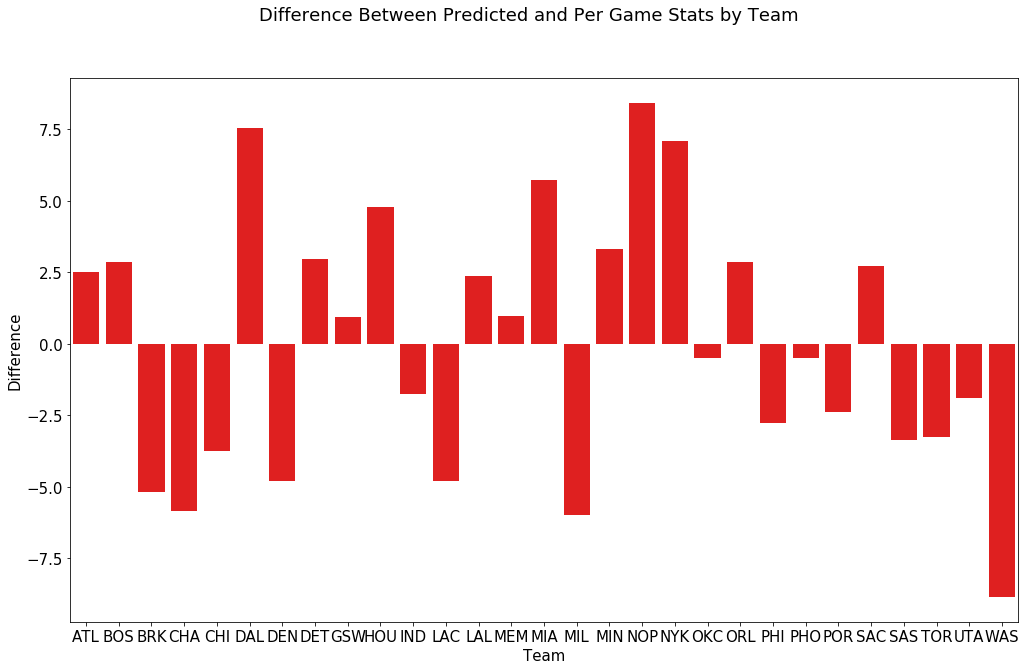

In [34]:
#Visualizations

#Seaborn works with dataframes rather than arrays
df = pd.DataFrame(
    {'Team': teams,
     'Difference': differences
    })

#Make labels readable
mpl.rcParams.update({'font.size': 15})

#Initialize the plot
fig, ax = plt.subplots(figsize=(17,10))

sns.barplot(x="Team", y="Difference", color = "red", data=df)
fig.suptitle("Difference Between Predicted and Per Game Stats by Team")

#Render the plot
plt.show()

# Summary

This tutorial covered one of the most basic applications of sports analytics in predicting individual player performance. In doing so, it also covered some of the fundamentals of data science in web-scraping for data collection and data cleanup. We also touched upon primitive clustering techniques when we calculated our similarity scores.

The beauty of sports analytics is that the sky really is the limit when it comes to even the simplest of problems. The model we chose was, albeit deliberately so, rather simple and there are many simple modifications/improvements you could make to try to improve this model. If you feel so inclined you could include more statistics in the weighted averages or even flip the model entirely and calculate similarity scores by player rather than by team.